In [1]:
import pandas as pd

from bs4 import BeautifulSoup
import requests
import re
import unicodedata

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

%matplotlib inline

#### 1. Webpage Patterns

##### List of Players in the National Team

The URL of the page which lists all the Argentinian players is *http://sofifa.com/players?na=52* which has *"na"* parameter equal to 52. Each national team will have its distinct *"na"* number (for Argentina it is 52).  

One single page only consists of a hundred players. To navigate to the next page, the *"offset"* parameter increments by 100. For example the first three pages of Argentina national team:

* First page: *http://sofifa.com/players?na=52* (*"offset"* parameter defaults to 0 in this case)
* Second page: *http://sofifa.com/players?na=52&offset=100*
* Third page: *http://sofifa.com/players?na=52&offset=200*

##### Individual Player Webpage

Each individual player has a unique ID and it is the last part of the URL of the individual player page. For example:

* Lionel Messi: *http://sofifa.com/player/158023* (ID is 158023)
* Gonzalo Higuain: *http://sofifa.com/player/167664* (ID is 167664)

The HTML source of the national team page includes the unique IDs of the Argentinian players. We will use these IDs to link to individual player page and extract information regarding the players' attributes.


#### 2. Explain in detail the code below.

##### Code Modifications

Below is the modified code to scrape Argentinian players' data. Please note that following modifications were performed:

* In order to make the code work for Python3 environment, 2 changes were made:
    * Print statement was updated according to Python3 syntax (i.e. with parentheses). The two print statements are eventually commented out to suppress lengthy output to this report
    * The byte representation of the text is explicitly decoded before performing regex pattern matching. Please see the line: **a=pat.match(text.decode('ascii'))**
* The original code extracts the player's name and attributes using regular expression. We also extract the positions that the player plays. This information is not used in the clustering algorithm. It is only used (in later parts of this report) to verify if the clustering results correspond to the positions a player plays.

In [2]:
# Q2

# Attributes to scrape
attributes=['Crossing','Finishing','Heading Accuracy',
 'Short Passing','Volleys','Dribbling','Curve',
 'Free Kick Accuracy','Long Passing','Ball Control','Acceleration',
 'Sprint Speed','Agility','Reactions','Balance',
 'Shot Power','Jumping','Stamina','Strength',
 'Long Shots','Aggression','Interceptions','Positioning',
 'Vision','Penalties','Composure','Marking',
 'Standing Tackle','Sliding Tackle','GK Diving',
 'GK Handling','GK Kicking','GK Positioning','GK Reflexes']
 
links=[]   # links containing the player pages to get
# Q3: Download first 300
for offset in ['0','100','200']:
    page=requests.get('http://sofifa.com/players?na=52&offset='+offset) # 52 is for Argentina team
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        links.append(link.get('href'))
links=['http://sofifa.com'+l for l in links if 'player/'in l]  # Get all the URL links to players' pages

#pattern regular expression 
pattern=r"""\s*([\w\s]*)"""   #file starts with empty spaces... players name...-other stuff
pattern += r""".*\d*\)\s*?([\w\s]*)Age""" # New addition: extraction of positions
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""  #for each attribute we have other stuff..number..attribute..other stuff
pat=re.compile(pattern, re.DOTALL)    #parsing multiline text

rows=[]
for j, link in enumerate(links):
    #print(j, link) # Print the index and URL link
    row=[link] # URL link to player's page
    playerpage=requests.get(link) # Get the player's page content and parse into HTML parser
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    text=playersoup.get_text()
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore') # Unicode normalise and encode using ASCII
    a=pat.match(text.decode('ascii')) # Match all the fields specified in the regular expressions
    row.append(a.group(1)) # Player's Name
    row.append(a.group(2).strip()) # New Addition: Position Info
    for i in range(3,len(attributes)+3): # The attributes of the players
        row.append(int(a.group(i).split()[0]))
    rows.append(row) # Append all the information of this player
    #print(row[1]) # Print Player Name
df=pd.DataFrame(rows,columns=['link','name','position']+attributes) # Initialise Panda Dataframe
df.to_csv('ArgentinaPlayers.csv',index=False) # Write to ArgentinaPlayers.csv

##### Code Explanation

Firstly, the list of player attributes to scrape from the webpage are defined in the code (a Python list named "attributes" stores the names of the attributes to be extracted from a player's stats). Then, the Python code to extract player's information is separated into three main parts:

1. Get the HTML source of the first three pages of Argentina national team and process them using HTML parser. Obtain the links to the 300 individual Argentinian player webapges. In details:
    - Python list named "links": stores all the extracted page links for each player
    - In the for loop:
        - Loops through list ['0','100','200'] and adds each number as "offset" parameter of the URL of Argentina national team page. Since each page only displays 100 players we need to go to offset=200 to get 300 players. The "requests.get" function creates a request object for each page
        - Each page's content (html code) is downloaded and parsed by the "BeautifulSoup" function with the argument "html.parser"
        - The "find_all" function of the BeautifulSoup object is used to get the all the contents with tag "a"
        - The "href" tag is used to locate and extract all the URL links with tag "a"
        - List comprehension to extract all the links that include "player/"
  
2. Regular expression pattern is defined to extract information from certain parts of the text:
    - First part of the expression searches all the leading whitespaces and player name at the start of the HTML document. It matches player name as the first subgroup
    - Second part of the expression is our new addition to the Python code. It matches the position that the player plays as the second subgroup (note that this information is not used for clustering, it is scraped simply to allow us to verify if the clustering results correspond to players' playing position), by searching for the text which sits between:
        - The player's ID number followed by closed parenthesis (e.g. **"218433)"**)
        - The literal string **"Age"**
    - Third part of the expression consists of all the attribute values and names. It matches all the attribute values as subgroups by searching for a numerical value followed by the attribute names
  
3. Extract information from the 300 Argentinian players' webpages and store them in a Python dataframe. In details:
    - Loop through the 300 links (to the individual Argentinian player's page) obtained in the first part:
        - Get the HTML source of each individual player page and parse it using HTML parser
        -  After getting the text of the HTML document, the unicode text is then normalised and encoded using ASCII (to convert Spanish-accented names into English equivalent)
        - Regular expression matching is then used to extract and save the information we are interested in
        - Store the extracted player information into a list named "row" (a for loop is used to append all the attribute values of a player, split function is used since we are only interested in the numerical values)
        - Append "row" to "rows" to create a list of lists
    - After collecting the information of all the 300 Argentinian players, a dataframe named "df" is created (using the list of lists) to store all these information


#### 3. How would you change the code to download the first 500 English players instead?

In order to change the above code to download the first 500 English players we need to make the following alternations:

- Extend the first for loop with "offset" parameter equal to '300' and '400' in order to get the first 500 players
- Change the URL in the first part to the one for English national team ("na" parameter is 14 for English team)
- Change the final filename where the extracted data is saved to

All the changes are marked with hash (i.e. "#") in the code below.

In [3]:
attributes=['Crossing','Finishing','Heading Accuracy',
 'Short Passing','Volleys','Dribbling','Curve',
 'Free Kick Accuracy','Long Passing','Ball Control','Acceleration',
 'Sprint Speed','Agility','Reactions','Balance',
 'Shot Power','Jumping','Stamina','Strength',
 'Long Shots','Aggression','Interceptions','Positioning',
 'Vision','Penalties','Composure','Marking',
 'Standing Tackle','Sliding Tackle','GK Diving',
 'GK Handling','GK Kicking','GK Positioning','GK Reflexes']
 
links=[]
for offset in ['0','100','200', '300', '400']: # Get First 500 English Players
    page=requests.get('http://sofifa.com/players?na=14&offset='+offset) # 14 is for England team
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        links.append(link.get('href'))
links=['http://sofifa.com'+l for l in links if 'player/'in l]

pattern=r"""\s*([\w\s]*)"""
pattern += r""".*\d*\)\s*?([\w\s]*)Age"""
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""
pat=re.compile(pattern, re.DOTALL)

rows=[]
for j, link in enumerate(links):
    #print(j, link)
    row=[link]
    playerpage=requests.get(link)
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    text=playersoup.get_text()
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    a=pat.match(text.decode('ascii'))
    row.append(a.group(1))
    row.append(a.group(2).strip())
    for i in range(3,len(attributes)+3):
        row.append(int(a.group(i).split()[0]))
    rows.append(row)
    #print(row[1])
df=pd.DataFrame(rows,columns=['link','name','position']+attributes)
df.to_csv('EnglishPlayers.csv',index=False) # Write to EnglishPlayers.csv

#### 4. Use the *sklearn.cluster.KMeans* Python class to cluster the players into 5 clusters.

We first read the 300 Argentinian players' data from the CSV file and use the "head()" function to inspect the first five rows.

In [4]:
argPlayers = pd.read_csv('ArgentinaPlayers.csv')
argPlayers.head()

,link,name,position,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
0,http://sofifa.com/player/158023,Lionel Messi,RW,77,95,71,88,85,97,89,...,74,94,13,28,26,6,11,15,14,8
1,http://sofifa.com/player/167664,Gonzalo Higuain,ST,68,92,80,73,88,84,69,...,70,84,12,22,18,5,12,7,5,10
2,http://sofifa.com/player/153079,Sergio Aguero,ST,70,90,68,79,85,89,82,...,80,90,13,20,12,13,15,6,11,14
3,http://sofifa.com/player/183898,Angel Di Maria,RW CM CAM,88,74,53,83,77,87,83,...,73,80,37,59,56,10,7,11,12,11
4,http://sofifa.com/player/211110,Paulo Dybala,ST CF,78,89,65,80,86,91,86,...,82,82,14,20,20,5,4,4,5,8


We would like to cluster the players based on their stats similarity, hence we will not use the first three columns (URL link, name, position) for clustering purpose.

The following code performs K-Means clustering (K = 5) using the players' stats.

In [5]:
# Number of clusters
numClusters = 5

argAttrs = argPlayers.iloc[ : , 3: ].as_matrix() # Only use the attributes for clustering
# Random seed value (random_state = 99) is used, 10 different runs (n_init = 10)
kmeans = KMeans(init='k-means++', n_clusters = numClusters, n_init = 10, random_state = 99).fit(argAttrs)

#### 5. By inspecting the clusters and looking up individual players online, try to assign meaningful labels to the clusters.

The 300 Argentinian players are now separated into five different clusters. To easily see who are the players (and their playing positions) in each cluster, we output the player information (from each of the five clusters) to five different CSV files.

In [6]:
# Q5

# See the link for football positons, https://en.wikipedia.org/wiki/Association_football_positions
for i in range(numClusters):
    filename = 'ArgentinaCluster' + str(i) + '.csv'
    argPlayers.iloc[kmeans.labels_ == i, 1:].to_csv(filename) # Output the names and positions of players from this cluster

From each of the CSV files, we can observe the following:

* **Cluster 0** includes a mix of **Defenders and Defensive Midfielders**. This group of players generally have high scores (especially marking and tackles) across most attributes, except Goalkeeper-specific attributes
* **Cluster 1** players are all **Goalkeepers** (also note that all Argentinian Goalkeepers reside only in this cluster). They have distinctly high attribute scores in Goalkeeper-specific attributes
* **Cluster 2** consists of mainly **Strikers**. They typically have high scores in finishing, shot power and penalties
* **Cluster 3** is dominated by **Centre-Backs** players, with high scores in strength, aggression and tackles
* **Cluster 4** consists of mainly **Midfielders and Forward Players**, with high scores in crossing, dribbling, sprint speed and agility

##### Visualising Player Attributes in Seven Attributes

Using the cluster information, we can visualise the score patterns of each cluster in the seven selected attributes (listed in Question 6): Crossing, Sprint Speed, Long Shots, Aggression, Marking, Finishing, and GK Handling.

In [7]:
# Add Cluster column to the dataframe
argPlayers['Cluster'] = kmeans.labels_

# Display the first 5 players
argPlayers.head()

,link,name,position,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,...,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Cluster
0,http://sofifa.com/player/158023,Lionel Messi,RW,77,95,71,88,85,97,89,...,94,13,28,26,6,11,15,14,8,4
1,http://sofifa.com/player/167664,Gonzalo Higuain,ST,68,92,80,73,88,84,69,...,84,12,22,18,5,12,7,5,10,2
2,http://sofifa.com/player/153079,Sergio Aguero,ST,70,90,68,79,85,89,82,...,90,13,20,12,13,15,6,11,14,4
3,http://sofifa.com/player/183898,Angel Di Maria,RW CM CAM,88,74,53,83,77,87,83,...,80,37,59,56,10,7,11,12,11,4
4,http://sofifa.com/player/211110,Paulo Dybala,ST CF,78,89,65,80,86,91,86,...,82,14,20,20,5,4,4,5,8,4


We now plot player attributes (of individual players) from the resulting clusters in a parallel coordinate system using the seven attributes under question 6.

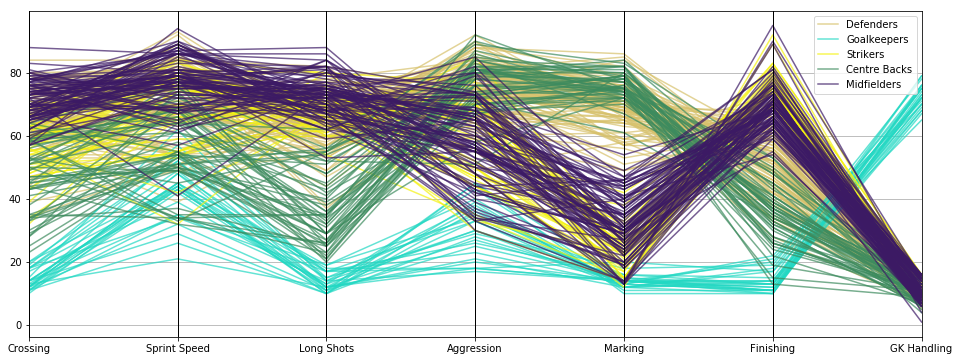

In [8]:
# assign names to clusters
argPlayers['Cluster Names'] = ['Defenders' if row == 0 else 
                  'Goalkeepers' if row == 1 else 
                  'Strikers' if row == 2 else
                  'Centre Backs' if row == 3 else
                  'Midfielders'
                  for row in argPlayers['Cluster']]

colPlot = ['Crossing', 'Sprint Speed', 'Long Shots', 'Aggression', 'Marking', 'Finishing', 'GK Handling'] + ['Cluster Names']

# sort data by Cluster
argPlayers = argPlayers.sort_values(['Cluster'], ascending= True)

plt.figure(figsize=(16,6))
parallel_coordinates(argPlayers.loc[ : , colPlot], 'Cluster Names', alpha = 0.7)

As seen above, the players in "Goalkeepers" cluster have noticeable difference in non-Goalkeeper specific skills (such as Sprint Speed). The players in the "Centre Backs" cluster also show significant difference in certain categories, such as Crossing, Sprint Speed and Long Shots.

The plot below shows the clusters centroids in these seven dimensions.

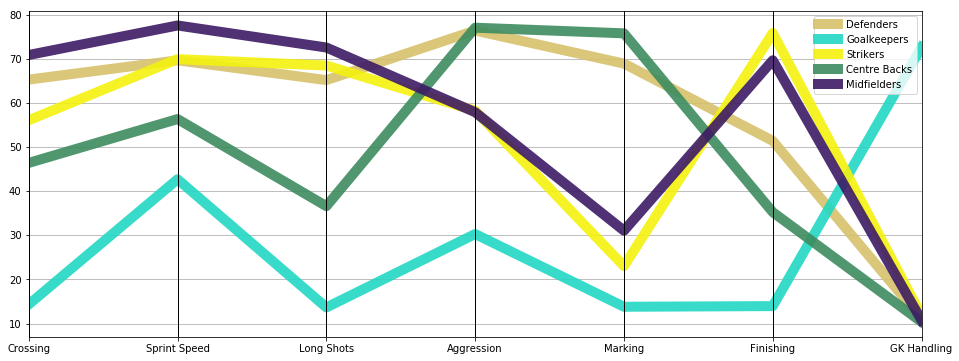

In [9]:
groupedData = argPlayers.groupby(argPlayers['Cluster Names']).mean()
groupedData['Cluster Names'] = groupedData.index

# sort data to have the same colors assigned to the same clusters as the previous plot
groupedData = groupedData.sort_values(['Cluster'], ascending= True)

plt.figure(figsize=(16,6))
parallel_coordinates(groupedData.loc[ : , colPlot], 'Cluster Names', linewidth=10, alpha = 0.9)

As seen above, the "Goalkeepers" cluster is the most different. The average GK Handling score is much higher than the other clusters.

Among the four remaining clusters, "Centre Backs" cluster is also quite different from the other three clusters. The "Midfielders" and "Strikers" cluster appear the most similar to each other. 

#### 6. For a new and unknown player, the following attributes are available:

- Crossing: 45
- Sprint Speed: 40
- Long Shots: 35
- Aggression: 45
- Marking: 60
- Finishing: 40
- GK Handling: 15

For each of your 5 clusters from Step 4, compute the cluster centroid. Assign the new player to the nearest cluster based on the distance to the cluster centroids, using only the available attributes.

Each of the cluster centroids has 34 dimensions. Since we only have these seven attributes for the new unknown player, we can only calculate the 2-norm distances to the five cluster centroids in these seven dimensions. Amongst these five distances (to the five cluster centroids), we pick the one with the lowest distance and the corresponding cluster is the nearest cluster.

The code below computes the centroids and calculates the distance to the new player (using the seven available attributes).

In [10]:
# Q6
newPlayerAttr = np.array([45, 40, 35, 45, 60, 40, 15]) # Attribute of new player

# Compute the five cluster centroids
centroids = kmeans.cluster_centers_

# Indices of the available attributes
selectedAttrs = [attributes.index('Crossing'), attributes.index('Sprint Speed'), 
                 attributes.index('Long Shots'), attributes.index('Aggression'),
                 attributes.index('Marking'), attributes.index('Finishing'), attributes.index('GK Handling')]

# For each centroid, obtain only the values of selected attributes/dimensions
centroidsSelected = centroids[ : , selectedAttrs]

# Calculate the distance to each of the 5 centroids, using only these selected attributes
distCentroids = np.linalg.norm(newPlayerAttr - centroidsSelected, axis = 1) # 2-norm distance

print("The nearest cluster to the new player is cluster", np.argmin(distCentroids))


The nearest cluster to the new player is cluster 3


As seen above, the new unknown player is closest to cluster 3: Centre-Backs cluster. We therefore assign the unknown player to the Centre-Backs cluster.

We also plot the new unknown player's attributes (in these 7 dimensions) and compare them with the cluster centroids.

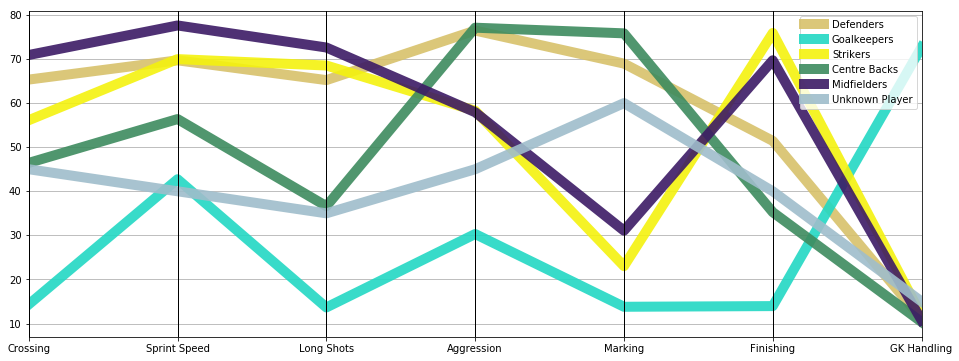

In [11]:
unknownPlayer = list(newPlayerAttr) + ['Unknown Player']

unknownPlayerData = groupedData.loc[:, colPlot]
unknownPlayerData.loc[len(unknownPlayerData)] = unknownPlayer

plt.figure(figsize=(16,6))
parallel_coordinates(unknownPlayerData, 'Cluster Names', linewidth=10, alpha = 0.9)

As observed in the above plot, the new player's attributes exhibit most similar pattern to the Centre-Backs cluster (than the other four clusters).